In [ ]:
from pcdvq.codebooks import *
from pcdvq.filters import *
from pcdvq.quantizer import *
from pcdvq.utils import *
from pcdvq.standart_requlazition import *
import torch, torch as t, numpy as np, matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM

In [ ]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Qwen tests

In [ ]:
dtype = t.float16
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen3-0.6B", device_map=dev, dtype=dtype)
model.eval();

In [ ]:
layers_t_q = get_linear_layers(model, qwen3_pcdvq_filter)

In [ ]:
l1 = next(iter(layers_t_q.values()))
w1 = l1.weight.detach().cpu()

In [ ]:
codebook = Codebook()
q = Quantizer(codebook)

In [ ]:
w1_q = q.quantize(w1.to(dev)).cpu()

INFO:pcdvq.quantizer:Original weights stats - min: -3.9062e-01, max: 3.1445e-01, mean: 3.7811e-05, std: 3.6629e-02
INFO:pcdvq.quantizer:Quantizing weights of shape torch.Size([3072, 1024]) with device cuda:0 and dtype torch.float16
INFO:pcdvq.quantizer:Quantization shapes - phis: torch.Size([393216, 7]), C_phis: torch.Size([65536, 7]), magnitudes: torch.Size([393216]), C_magnitudes: torch.Size([4]), chunk_size: 1024, phi_chunk_size: 1024


phi chunks:   0%|          | 0/384 [00:00<?, ?it/s]

INFO:pcdvq.quantizer:Quantized weights stats - min: -1.6415e-01, max: 1.8073e-01, mean: 1.5204e-03, std: 1.9737e-02


<matplotlib.legend.Legend>

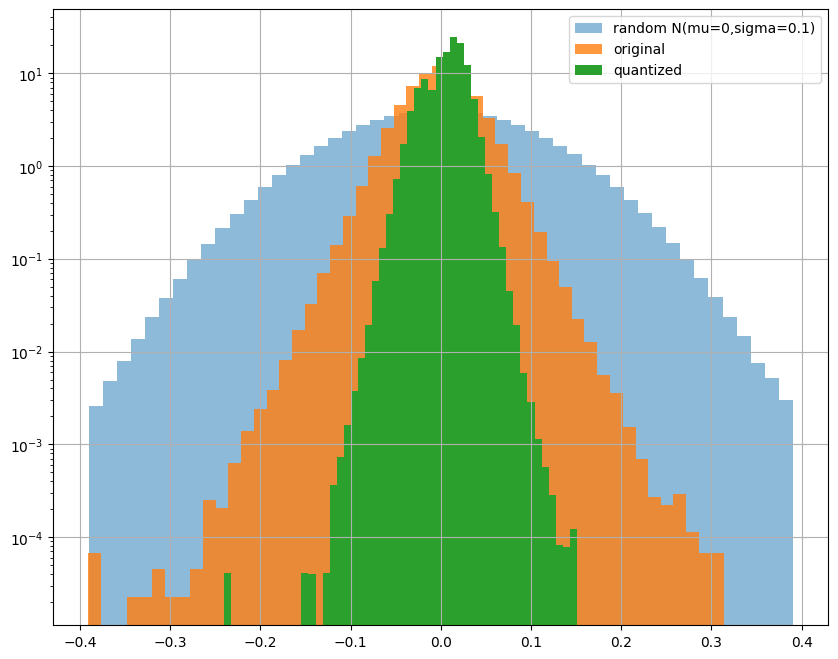

In [ ]:
bins = 50
plt.figure(figsize=(10,8))
plt.hist(t.randn_like(w1.flatten())*0.1, label='random N(mu=0,sigma=0.1)', density=True, bins=bins, alpha=0.5)
plt.hist(w1.flatten(), label='original', density=True, bins=bins, alpha=0.8)
plt.hist(w1_q.flatten(), label='quantized', density=True, bins=bins, alpha=1)
plt.grid()
plt.yscale('log')
plt.legend()

## Simple model

In [ ]:
tfm = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
ds = datasets.MNIST('../data', train=True, download=True, transform=tfm)
dl = DataLoader(ds, batch_size=128, shuffle=True, num_workers=6, persistent_workers=True)

model = nn.Sequential(nn.Flatten(), nn.Linear(784, 128), nn.ReLU(), nn.Linear(128, 10)).to(dev)
opt = optim.SGD(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

In [ ]:
for epoch in tqdm(range(5)):
    for xb,yb in tqdm(dl):
        xb,yb = xb.to(dev),yb.to(dev)
        opt.zero_grad()
        loss = loss_func(model(xb), yb)
        loss.backward()
        opt.step()
    print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 0, Loss: 1.6326


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, Loss: 1.0025


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, Loss: 0.8757


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, Loss: 0.6748


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, Loss: 0.6042


In [ ]:
def calc_acc(mdl, dl):
    'calculates accuracy'
    mdl.eval()
    dev,corr,n = next(mdl.parameters()).device, 0., 0
    with t.no_grad():
        for xb,yb in dl:
            xb,yb = xb.to(dev),yb.to(dev)
            corr += (mdl(xb).argmax(dim=1)==yb).sum().item()
            n += len(xb)
    return corr/n

In [ ]:
print('accuracy', calc_acc(model, dl))

accuracy 0.8593333333333333


### Hadamard transform scaling

In [ ]:
q_size = 8

W = model[1].weight.detach().reshape(-1, q_size).cpu()

In [ ]:
tfm = RandomizedHadamard(q_size)
W_t, scale = tfm(W)
W_t = W_t.cpu()

<matplotlib.legend.Legend>

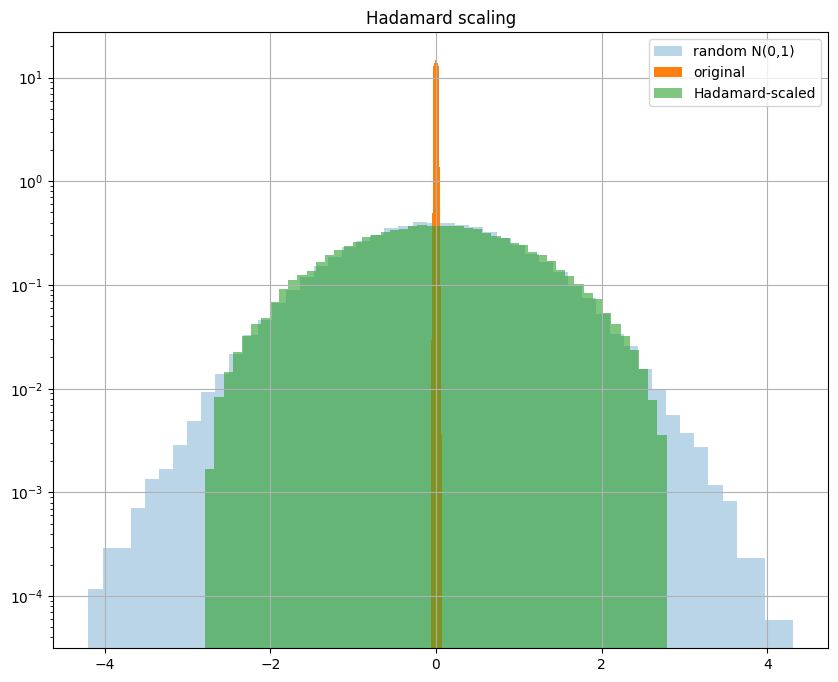

In [ ]:
bins = 50
plt.figure(figsize=(10,8))
plt.hist(t.randn_like(W.flatten()), label='random N(0,1)', density=True, bins=bins, alpha=0.3)
plt.hist(W.flatten(), label='original', density=True, bins=bins, alpha=1)
plt.hist(W_t.flatten(), label='Hadamard-scaled', density=True, bins=bins, alpha=0.6)
plt.title("Hadamard scaling")
plt.grid()
plt.yscale('log')
plt.legend()